In [1]:
import sys
import subprocess
python = sys.executable
subprocess.check_call(
    [python, '-m', 'pip', 'install', '--upgrade', '-r', 'requirement.txt'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT  #Suppress error messages
)

print(">>> requirements checked <<<\n")

>>> requirements checked <<<



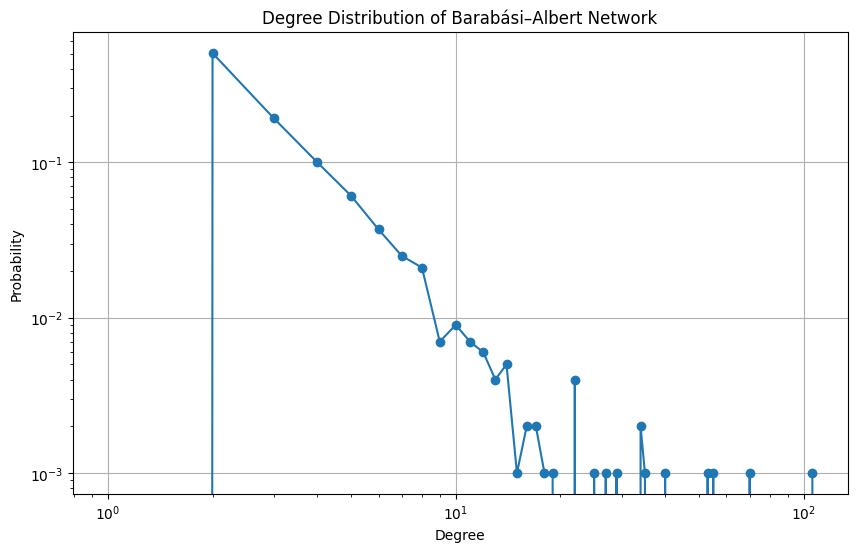

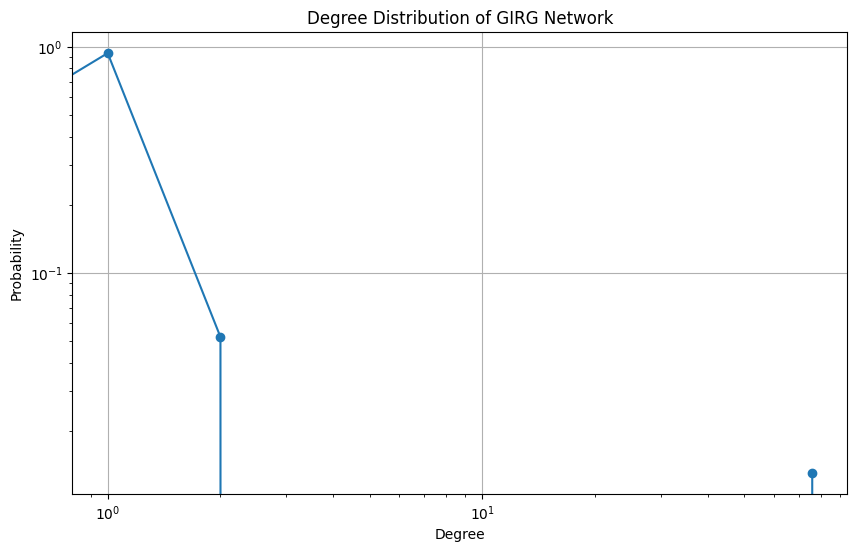

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import powerlaw

def generate_ba_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def generate_girg_network(n, d, tau, alpha, expected_weight):
    class GIRG:
        def __init__(self, n, d, tau, alpha, expected_weight):
            self.n = n
            self.d = d
            self.tau = tau
            self.alpha = alpha
            self.expected_weight = expected_weight
            self.positions = np.random.uniform(size=(n, d))
            self.weights = self._generate_weights(tau, n)
            self.graph = self._generate_graph()

        def _generate_weights(self, tau, size):
            weights = powerlaw.Power_Law(xmin=1, parameters=[tau-1]).generate_random(size)
            weights = weights / np.mean(weights) * self.expected_weight
            return weights

        def _distance_matrix(self):
            return squareform(pdist(self.positions))

        def _generate_graph(self):
            dist_matrix = self._distance_matrix()
            graph = nx.Graph()
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    if dist_matrix[i, j] == 0:
                        dist_matrix[i, j] = np.inf  # Avoid division by zero
                    p = 1 - np.exp(- (self.weights[i] * self.weights[j]) / (dist_matrix[i, j] ** self.alpha))
                    if np.random.random() < p:
                        graph.add_edge(i, j)
            return graph

    girg = GIRG(n, d, tau, alpha, expected_weight)
    return girg.graph

# Parameters for network generation
n = 1000  # Ensure both networks have the same number of nodes
m = 2
d = 2
tau = 2.5
alpha = 2
expected_weight = 1

# Generate networks
G_ba = generate_ba_network(n, m)
G_girg = generate_girg_network(n, d, tau, alpha, expected_weight)

# Plotting functions for degree distribution
def plot_degree_distribution(G, title):
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    degree_probs = degree_counts / sum(degree_counts)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(range(len(degree_probs)), degree_probs, marker='o')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
# Function to choose and generate network based on type
def choose_network(network_type, n):
    if network_type == 'BA':
        return generate_ba_network(n, m)
    elif network_type == 'GIRG':
        return generate_girg_network(n, d, tau, alpha, expected_weight)
    else:
        raise ValueError("Unknown network type")

# Plot degree distributions
plot_degree_distribution(G_ba, 'Degree Distribution of Barabási–Albert Network')
plot_degree_distribution(G_girg, 'Degree Distribution of GIRG Network')

In [3]:
# UPN-SEIRD model parameters
beta_u = 0.1
beta_p = 0.2 * beta_u
beta_n = 0.2 * beta_u
sigma = 1 / 10
gamma = 1 / 14
f = 0.01
kappa = 1
lambda_plus = 1.0
lambda_minus = 1.0
delta_plus = 1 / 3
delta_minus = 1 / 3

# Initial conditions
initial_infected = 50
initial_aware = 10
i_0 = initial_infected / n
a_0 = initial_aware / n

# Function to initialize state variables
def initialize_states(N, initial_infected, initial_aware, i_0, a_0):
    S = np.full(N, 1.0, dtype=float)
    E = np.zeros(N, dtype=float)
    I = np.zeros(N, dtype=float)
    R = np.zeros(N, dtype=float)
    D = np.zeros(N, dtype=float)
    U = np.full(N, 1.0 - a_0, dtype=float)
    P = np.zeros(N, dtype=float)
    N_nodes = np.zeros(N, dtype=float)

    infected_nodes = np.random.choice(np.arange(N), initial_infected, replace=False)
    aware_nodes = np.random.choice(np.arange(N), initial_aware, replace=False)

    I[infected_nodes] = 1
    U[aware_nodes] = 0
    P[aware_nodes] = 1 - a_0

    U[aware_nodes] = 0
    P[aware_nodes] = 1
    N_nodes[aware_nodes] = 0
    total = U + P + N_nodes
    U /= total
    P /= total
    N_nodes /= total

    return S, E, I, R, D, U, P, N_nodes

# Function to run the simulation
def simulate_upn_seird_seperate(adjacency_matrix_epidemic, adjacency_matrix_info, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0):
    N = len(adjacency_matrix_epidemic)
    S, E, I, R, D, U, P, N_nodes = initialize_states(N, initial_infected, initial_aware, i_0, a_0)

    time_steps = np.arange(0, t_max, dt)

    S_list = []
    E_list = []
    I_list = []
    R_list = []
    D_list = []
    U_list = []
    P_list = []
    N_list = []

    print("Starting the simulation...")
    epsilon = 1e-10

    for t_index, t in enumerate(time_steps):
        if t_index % 100 == 0:
            print(f"Simulation at time step {t_index}/{len(time_steps)} (time = {t:.1f})")
        
        dot_I = adjacency_matrix_epidemic.dot(I)
        dot_P = adjacency_matrix_info.dot(P)
        dot_N_nodes = adjacency_matrix_info.dot(N_nodes)
        
        new_E = (beta_u * S * dot_I) * dt
        new_I = (sigma * E) * dt
        new_R = ((1 - f) * gamma * I) * dt
        new_D = (f * gamma * I) * dt
        new_P = (lambda_plus * U * dot_P + kappa * I * U) * dt
        new_U_from_P = (delta_plus * P) * dt
        new_N = (lambda_minus * U * dot_N_nodes + kappa * I * U) * dt
        new_U_from_N = (delta_minus * N_nodes) * dt
        
        np.clip(S - new_E, 0, 1, out=S)
        np.clip(E + new_E - new_I, 0, 1, out=E)
        np.clip(I + new_I - new_R - new_D, 0, 1, out=I)
        np.clip(R + new_R, 0, 1, out=R)
        np.clip(D + new_D, 0, 1, out=D)
        np.clip(U - new_P - new_N + new_U_from_P + new_U_from_N, 0, 1, out=U)
        np.clip(P + new_P - new_U_from_P, 0, 1, out=P)
        np.clip(N_nodes + new_N - new_U_from_N, 0, 1, out=N_nodes)
        
        UPN_total = U + P + N_nodes + epsilon
        U /= UPN_total
        P /= UPN_total
        N_nodes /= UPN_total
        
        S_list.append(np.mean(S))
        E_list.append(np.mean(E))
        I_list.append(np.mean(I))
        R_list.append(np.mean(R))
        D_list.append(np.mean(D))
        U_list.append(np.mean(U))
        P_list.append(np.mean(P))
        N_list.append(np.mean(N_nodes))

    print("Simulation complete. Plotting results...")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

    ax1.set_xlim(0, 150)
    ax1.plot(time_steps, S_list, label='Susceptible (S)')
    ax1.plot(time_steps, E_list, label='Exposed (E)')
    ax1.plot(time_steps, I_list, label='Infected (I)')
    ax1.plot(time_steps, R_list, label='Recovered (R)')
    ax1.plot(time_steps, D_list, label='Deceased (D)')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Proportion')
    ax1.legend()
    ax1.set_title('SEIRD Model Dynamics')

    ax2.set_xlim(0, 10)
    ax2.plot(time_steps, U_list, label='Unaware (U)')
    ax2.plot(time_steps, P_list, label='Positive Spreader (P)')
    ax2.plot(time_steps, N_list, label='Negative Spreader (N)')
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Proportion')
    ax2.legend()
    ax2.set_title('UPN Model Dynamics')

    plt.tight_layout()
    plt.show()

Starting the simulation...
Simulation at time step 0/15000 (time = 0.0)
Simulation at time step 100/15000 (time = 1.0)
Simulation at time step 200/15000 (time = 2.0)
Simulation at time step 300/15000 (time = 3.0)
Simulation at time step 400/15000 (time = 4.0)
Simulation at time step 500/15000 (time = 5.0)
Simulation at time step 600/15000 (time = 6.0)
Simulation at time step 700/15000 (time = 7.0)
Simulation at time step 800/15000 (time = 8.0)
Simulation at time step 900/15000 (time = 9.0)
Simulation at time step 1000/15000 (time = 10.0)
Simulation at time step 1100/15000 (time = 11.0)
Simulation at time step 1200/15000 (time = 12.0)
Simulation at time step 1300/15000 (time = 13.0)
Simulation at time step 1400/15000 (time = 14.0)
Simulation at time step 1500/15000 (time = 15.0)
Simulation at time step 1600/15000 (time = 16.0)
Simulation at time step 1700/15000 (time = 17.0)
Simulation at time step 1800/15000 (time = 18.0)
Simulation at time step 1900/15000 (time = 19.0)
Simulation at t

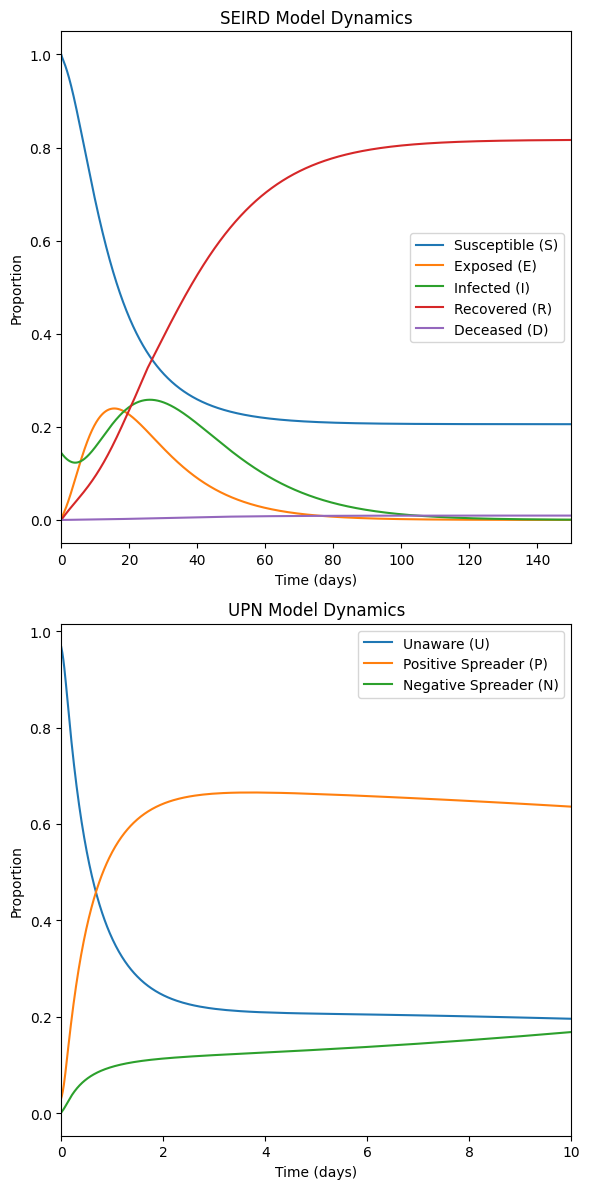

In [5]:
# Parameters
t_max = 150  # Maximum time
dt = 0.01  # Time step

# Choose networks
layer_type = 'GIRG'  # Change as needed: 'BA', 'GIRG'

n = 1000  # Target number of nodes

# Generate the network for both layers
G = choose_network(layer_type, n)

# Convert network to adjacency matrix
adjacency_matrix = nx.to_numpy_array(G)

# Run the simulation
simulate_upn_seird_seperate(adjacency_matrix, adjacency_matrix, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)